In [30]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error,r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_california_housing
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
import matplotlib.pyplot as plt

In [31]:
class GradientBoostingTree:
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3, loss='squared_error'):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.loss = loss
        self.trees = []
        self.init_prediction = None

    def _loss_gradient(self, y, y_pred):
        """
        Compute the gradient of the loss function with respect to predictions.
        Supports squared error, absolute error, and Huber loss.
        """
        if self.loss == 'squared_error':
            return y - y_pred  # Negative gradient for squared error
        elif self.loss == 'absolute_error':
            return np.sign(y - y_pred)  # Gradient for MAE
        elif self.loss == 'huber':
            delta = 1.0  # You can tune this value
            error = y - y_pred
            return np.where(np.abs(error) <= delta, error, delta * np.sign(error))  # Huber gradient
        else:
            raise NotImplementedError(f"Loss {self.loss} is not implemented.")

    def fit(self, X, y):
        # Initialize prediction
        self.init_prediction = np.mean(y)
        y_pred = np.full_like(y, self.init_prediction, dtype=np.float64)

        for _ in range(self.n_estimators):
            # Compute pseudo-residuals
            residuals = self._loss_gradient(y, y_pred)

            # Fit a weak learner to residuals
            tree = DecisionTreeRegressor(max_depth=self.max_depth)
            tree.fit(X, residuals)
            self.trees.append(tree)

            # Update predictions
            y_pred += self.learning_rate * tree.predict(X)

    def predict(self, X):
        y_pred = np.full((X.shape[0],), self.init_prediction, dtype=np.float64)
        for tree in self.trees:
            y_pred += self.learning_rate * tree.predict(X)
        return y_pred


    def evaluate(self, y_true, y_pred):
        metrics = {
            "Mean Squared Error": mean_squared_error(y_true, y_pred),
            "Mean Absolute Error": mean_absolute_error(y_true, y_pred),
            "R2 Score": r2_score(y_true, y_pred)
        }
        return metrics

    def feature_importances(self):
        """
        Calculate and return feature importances by averaging importances from all trees.
        """
        importances = np.zeros(self.trees[0].n_features_in_)
        for tree in self.trees:
            importances += tree.feature_importances_
        return importances / len(self.trees)



### Dataset Load

In [32]:
# Load California Housing data
X, y = fetch_california_housing(return_X_y=True)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Gradient Boosting Tree
gbt = GradientBoostingTree(n_estimators=100, learning_rate=0.1, max_depth=3, loss='squared_error')
gbt.fit(X_train, y_train)

# Predict and evaluate
y_pred = gbt.predict(X_test)


### Train Gradient Boosting Tree with Additional Loss Function (Huber Loss)

In [33]:
print("Training Gradient Boosting Tree with Huber Loss...")
gbt_huber = GradientBoostingTree(n_estimators=100, learning_rate=0.1, max_depth=3, loss='huber')
gbt_huber.fit(X_train, y_train)

Training Gradient Boosting Tree with Huber Loss...


### Predict and Evaluate Model

In [34]:
y_pred_huber = gbt_huber.predict(X_test)
metrics_huber = gbt_huber.evaluate(y_test, y_pred_huber)
print(f"Mean Squared Error with Huber Loss: {metrics_huber['Mean Squared Error']:.4f}")
print(f"Mean Absolute Error with Huber Loss: {metrics_huber['Mean Absolute Error']:.4f}")
print(f"R2 Score with Huber Loss: {metrics_huber['R2 Score']:.4f}")

Mean Squared Error with Huber Loss: 0.3059
Mean Absolute Error with Huber Loss: 0.3729
R2 Score with Huber Loss: 0.7665


### Feature Importance

In [35]:
print("\nFeature Importances (Huber Loss Model):")
importances_huber = gbt_huber.feature_importances()
for name, importance in zip(feature_names, importances_huber):
    print(f"{name}: {importance:.4f}")



Feature Importances (Huber Loss Model):
MedInc: 0.2382
HouseAge: 0.0787
AveRooms: 0.0195
AveBedrms: 0.0393
Population: 0.0103
AveOccup: 0.1124
Latitude: 0.2338
Longitude: 0.2678


### Plot Feature Importance

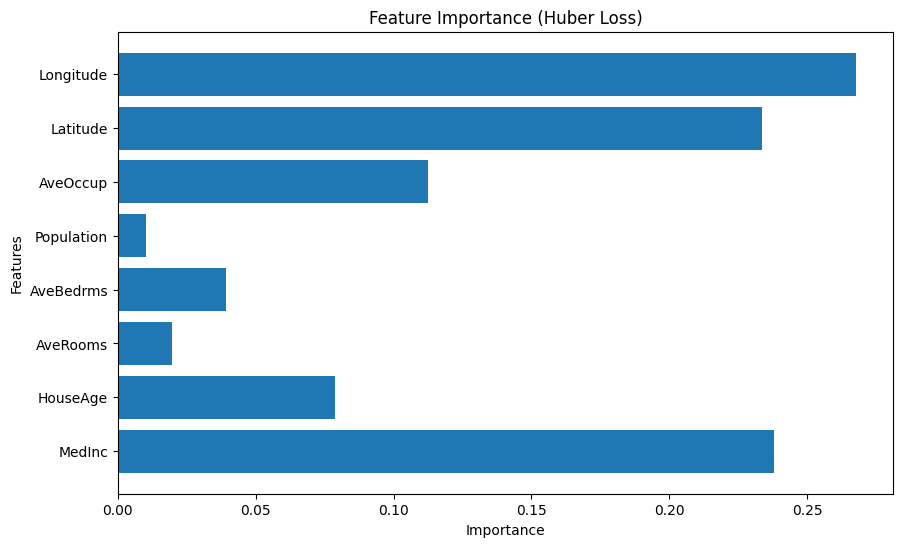

In [36]:
plt.figure(figsize=(10, 6))
plt.barh(feature_names, importances_huber)
plt.xlabel("Importance")
plt.ylabel("Features")
plt.title("Feature Importance (Huber Loss)")
plt.show()


### Train Gradient Boosting Tree with Squared Error Loss for Comparison

In [37]:
print("\nTraining Gradient Boosting Tree with Squared Error Loss...")
gbt_squared = GradientBoostingTree(n_estimators=100, learning_rate=0.1, max_depth=3, loss='squared_error')
gbt_squared.fit(X_train, y_train)



Training Gradient Boosting Tree with Squared Error Loss...


### Predict and Evaluate Model

In [38]:
y_pred_squared = gbt_squared.predict(X_test)
mse_squared = gbt_squared.evaluate(y_test, y_pred_squared)
print(f"Mean Squared Error with Huber Loss: {metrics_huber['Mean Squared Error']:.4f}")
print(f"Mean Absolute Error with Huber Loss: {metrics_huber['Mean Absolute Error']:.4f}")
print(f"R2 Score with Huber Loss: {metrics_huber['R2 Score']:.4f}")

Mean Squared Error with Huber Loss: 0.3059
Mean Absolute Error with Huber Loss: 0.3729
R2 Score with Huber Loss: 0.7665


### Feature Importance (Squared Error Model)

In [39]:
print("\nFeature Importances (Squared Error Loss Model):")
importances_squared = gbt_squared.feature_importances()
for name, importance in zip(feature_names, importances_squared):
    print(f"{name}: {importance:.4f}")



Feature Importances (Squared Error Loss Model):
MedInc: 0.1884
HouseAge: 0.0659
AveRooms: 0.0379
AveBedrms: 0.0472
Population: 0.0112
AveOccup: 0.1015
Latitude: 0.2711
Longitude: 0.2769


### Plot Feature Importance

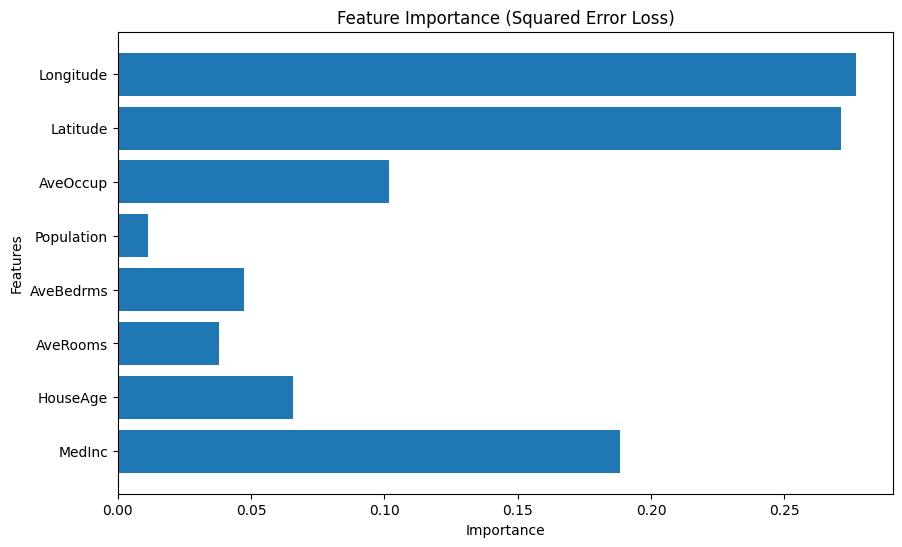

In [40]:
plt.figure(figsize=(10, 6))
plt.barh(feature_names, importances_squared)
plt.xlabel("Importance")
plt.ylabel("Features")
plt.title("Feature Importance (Squared Error Loss)")
plt.show()